In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
from pathlib import Path
from typing import Any
from logging import INFO, DEBUG
import json
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from flwr.common import log, ndarrays_to_parameters
import matplotlib.pyplot as plt
import math

from src.common.client_utils import (
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    get_device,
    get_model_parameters,
    aggregate_weighted_average,
)


from src.flwr_core import (
    set_all_seeds,
    get_paths,
    decompress_dataset,
    get_flower_client_generator,
    sample_random_clients,
    get_federated_evaluation_function,
)

from src.estimate import (
    compute_critical_batch,
)

from src.experiments_simulation import (
    run_simulation,
    centralized_experiment,
)

from src.utils import get_centralized_acc_from_hist
import itertools

PathType = Path | str | None

In [4]:
def load_experiment(save_file_name):
    with open(save_file_name, "r") as f:
        results_dict = json.load(f)
    return results_dict

def save_experiment(save_file_name, results_dict):
    if os.path.exists(save_file_name):
        print(f"File {save_file_name} already exists")
        return
    with open(save_file_name, "w") as f:
        json.dump(results_dict, f, indent=4)

In [5]:
import pickle

def save_federated_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    if os.path.exists(save_file_name):
        raise FileExistsError(f"File {save_file_name} already exists")
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_federated_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history']
    )

**Global variables**

In [6]:
set_all_seeds()

PATHS = get_paths()

HOME_DIR = PATHS["home_dir"]
DATASET_DIR = PATHS["dataset_dir"]
DATA_DIR = PATHS["data_dir"]
CENTRALIZED_PARTITION = PATHS["centralized_partition"]
CENTRALIZED_MAPPING = PATHS["centralized_mapping"]
FEDERATED_PARTITION = PATHS["federated_partition"]

# extract dataset from tar.gz
decompress_dataset(PATHS)

In [7]:
NETWORK_GENERATOR = get_network_generator()
SEED_NET = NETWORK_GENERATOR()
SEED_MODEL_PARAMS = get_model_parameters(SEED_NET)
CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

In [8]:
# Centralized experiments
centralized_experiment_batch_sizes = [32, 64, 128, 256, 512, 1024]

# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in the FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(data_dir=DATA_DIR,mapping=CENTRALIZED_MAPPING, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=DATA_DIR, mapping=CENTRALIZED_MAPPING, name="test")

centralized_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
    "target_accuracy": 0.60,
}

In [9]:
# FL experiments
experiment_batch_sizes = [16, 32, 64, 128, 256]
cohort_sizes = [5, 10, 20, 50, 75, 100]


# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    #"max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 10
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(SEED_MODEL_PARAMS)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=NETWORK_GENERATOR,
    criterion=nn.CrossEntropyLoss(),
    max_batches=None if "max_batches" not in federated_test_config else federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False


CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

list_of_ids = sample_random_clients(
    num_total_clients, federated_train_config["batch_size"],
    CID_CLIENT_GENERATOR,
)

federated_client_generator = (
    get_flower_client_generator(
        NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-03-01 11:29:48,393 | flwr_core.py:105 | cid: 2530
INFO flwr 2025-03-01 11:29:48,492 | flwr_core.py:105 | cid: 2184
INFO flwr 2025-03-01 11:29:48,495 | flwr_core.py:105 | cid: 2907
INFO flwr 2025-03-01 11:29:48,497 | flwr_core.py:105 | cid: 1498
INFO flwr 2025-03-01 11:29:48,500 | flwr_core.py:105 | cid: 2338
INFO flwr 2025-03-01 11:29:48,502 | flwr_core.py:105 | cid: 2399
INFO flwr 2025-03-01 11:29:48,504 | flwr_core.py:105 | cid: 2997
INFO flwr 2025-03-01 11:29:48,506 | flwr_core.py:105 | cid: 678
INFO flwr 2025-03-01 11:29:48,509 | flwr_core.py:105 | cid: 3175
INFO flwr 2025-03-01 11:29:48,512 | flwr_core.py:105 | cid: 1363
INFO flwr 2025-03-01 11:29:48,514 | flwr_core.py:105 | cid: 1571
INFO flwr 2025-03-01 11:29:48,516 | flwr_core.py:105 | cid: 2600
INFO flwr 2025-03-01 11:29:48,519 | flwr_core.py:105 | cid: 1473
INFO flwr 2025-03-01 11:29:48,521 | flwr_core.py:105 | cid: 1260
INFO flwr 2025-03-01 11:29:48,524 | flwr_core.py:105 | cid: 1603
INFO flwr 2025-03-01 11:29

## **Experiments**

### LR scaling

Some rules usually are:

**Linear scaling**

$$ \text{LR} \propto \text{batch size} $$

so, starting with 0.1 at 256, we get then, 0.05 at 128, 0.025 at 64, 0.0125 at 32, 0.00625 at 16.

However, this is not always the case, and it depends on the model, the dataset, the optimizer, etc.

We can also use:

**Sqrt scaling**

$$ \text{LR} \propto \sqrt{\text{batch size}} $$

Starting with 0.1 at 256, we get then, sqrt(128/256) * 0.1 at 128, sqrt(64/256) * 0.1 at 64, sqrt(32/256) * 0.1 at 32, sqrt(16/256) * 0.1 at 16.


Or we can use **Learning Rate Finders**.

***However***, in Federated Learning usually people use lower learning rates.

While in centralized learning its normal to use LR = 0.1 to batch size = 256, in federated learning its usual to use 0.005-0.01 for batch sizes 16-32.


# Experiment 1

### **Centralized run with varying batch sizes**

In [ ]:
centralized_experiment_results = []

for batch_size in centralized_experiment_batch_sizes:
    if batch_size <= 256:
        continue
    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["learning_rate"] = ratio * 0.1

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )
    
    centralized_results = centralized_experiment(centralized_train_config, centralized_test_config, centralized_train_loader, centralized_test_loader, get_device(), NETWORK_GENERATOR())
    centralized_experiment_results.append((batch_size, centralized_results))


In [8]:
for batch_size, results in centralized_experiment_results:
    save_experiment(f"centralized_experiment_results_{batch_size}.json", results)

In [16]:
centralized_experiment_results = []
for batch_size in centralized_experiment_batch_sizes:
    centralized_experiment_results.append((batch_size, load_experiment(f"centralized_experiment_results_{batch_size}.json")))

Their plot:

Y-axis: $\epsilon_\text{opt}(B) / \epsilon_\text{max}$, which is $\frac{1}{1+\Beta_{noise}/B}$, B batch size, $\Beta_{noise}$ is the noise scale.

X-axis: $\frac{B}{\Beta_{noise}}$, B batch size, $\Beta_{noise}$ is noise scale.

INFO flwr 2025-02-28 21:02:48,179 | 2931404038.py:22 | Batch size: 32
INFO flwr 2025-02-28 21:02:48,181 | 2931404038.py:23 | Total Training Time (s): 1.7968597412109375
INFO flwr 2025-02-28 21:02:48,182 | 2931404038.py:24 | Compute Budget (samples): 22400
INFO flwr 2025-02-28 21:02:48,184 | 2931404038.py:22 | Batch size: 64
INFO flwr 2025-02-28 21:02:48,184 | 2931404038.py:23 | Total Training Time (s): 1.2245638370513916
INFO flwr 2025-02-28 21:02:48,185 | 2931404038.py:24 | Compute Budget (samples): 32000
INFO flwr 2025-02-28 21:02:48,186 | 2931404038.py:22 | Batch size: 128
INFO flwr 2025-02-28 21:02:48,187 | 2931404038.py:23 | Total Training Time (s): 0.7908370494842529
INFO flwr 2025-02-28 21:02:48,187 | 2931404038.py:24 | Compute Budget (samples): 38400
INFO flwr 2025-02-28 21:02:48,188 | 2931404038.py:22 | Batch size: 256
INFO flwr 2025-02-28 21:02:48,188 | 2931404038.py:23 | Total Training Time (s): 0.48624491691589355
INFO flwr 2025-02-28 21:02:48,189 | 2931404038.py:24 | Compu

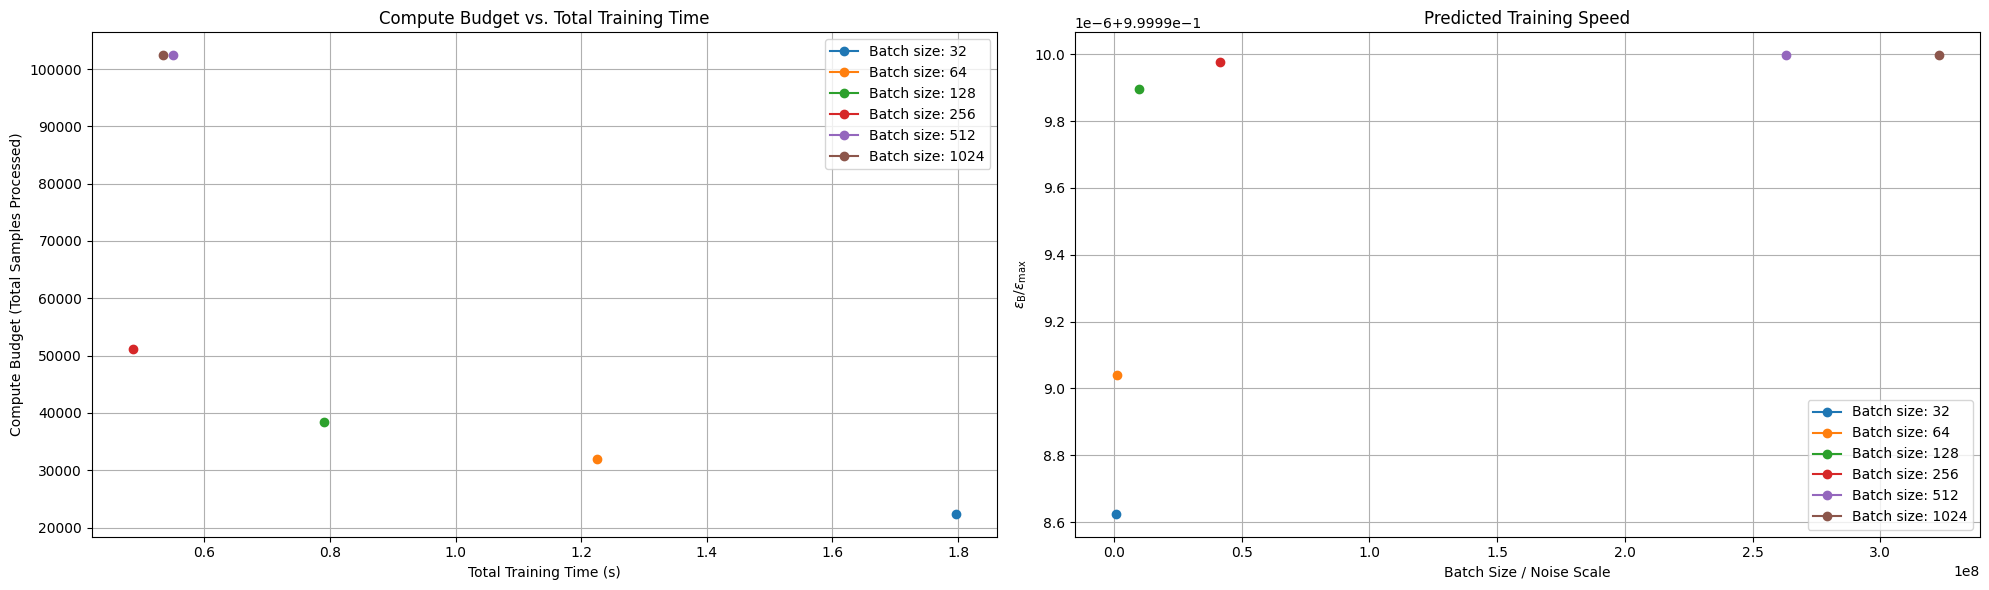

In [19]:
# Assume centralized_experiment_results is a list of tuples:
# (batch_size, results)
# where results is a dict containing:
#   - "compute_budgets": samples per epoch
#   - "training_time": time per epoch
#   - "noise_scales": list of noise scale values per epoch

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
centralized_experiment_results = [
    (batch_size, load_experiment(f"centralized_experiment_results_{batch_size}.json"))
    for batch_size in centralized_experiment_batch_sizes
]
# Left subplot: Compute Budget vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    if batch_size == 16:
        continue
    # Calculate cumulative training time (sum over epochs)
    cumulative_time = np.sum(results["training_time"])
    compute_budget = np.sum(results["compute_cost"])
    axes[0].plot(cumulative_time, compute_budget, marker='o', label=f"Batch size: {batch_size}")
    
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Total Training Time (s): {cumulative_time}")
    log(INFO, f"Compute Budget (samples): {compute_budget}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Noise Scale vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    noise_scale = np.mean(results["noise_scales"]) # do we average ??

    x_axis = batch_size / noise_scale
    y_axis = 1 / (1 + (noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")
    
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Cumulative Training Time (s): {cumulative_time}")
    log(INFO, f"Noise Scale: {noise_scale}")


axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


We can also observe that increasing batch size appears does in fact alter performance.

Furthermore, both $\beta_{\text{simple}}$ computation and the empirical results seem to indicate optimal batch sizes with magnitudes in the hundreds (100-1000).

# Experiment 2

### **FL run with varying batch sizes**

In [ ]:
total_batch_results = []

for batch_size in experiment_batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["client_learning_rate"] = ratio * 0.01 # Same as centralized, but should be lower for FL

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    total_batch_results.append((batch_size, parameters_for_each_round, hist))

In [10]:
for batch_size, parameters, hist in total_batch_results:
    save_federated_experiment(f"federated_batch_results_{batch_size}.pkl", batch_size, parameters, hist)

In [21]:
total_batch_results = []
for batch_size in experiment_batch_sizes:
    total_batch_results.append(load_federated_experiment(f"federated_batch_results_{batch_size}.pkl"))

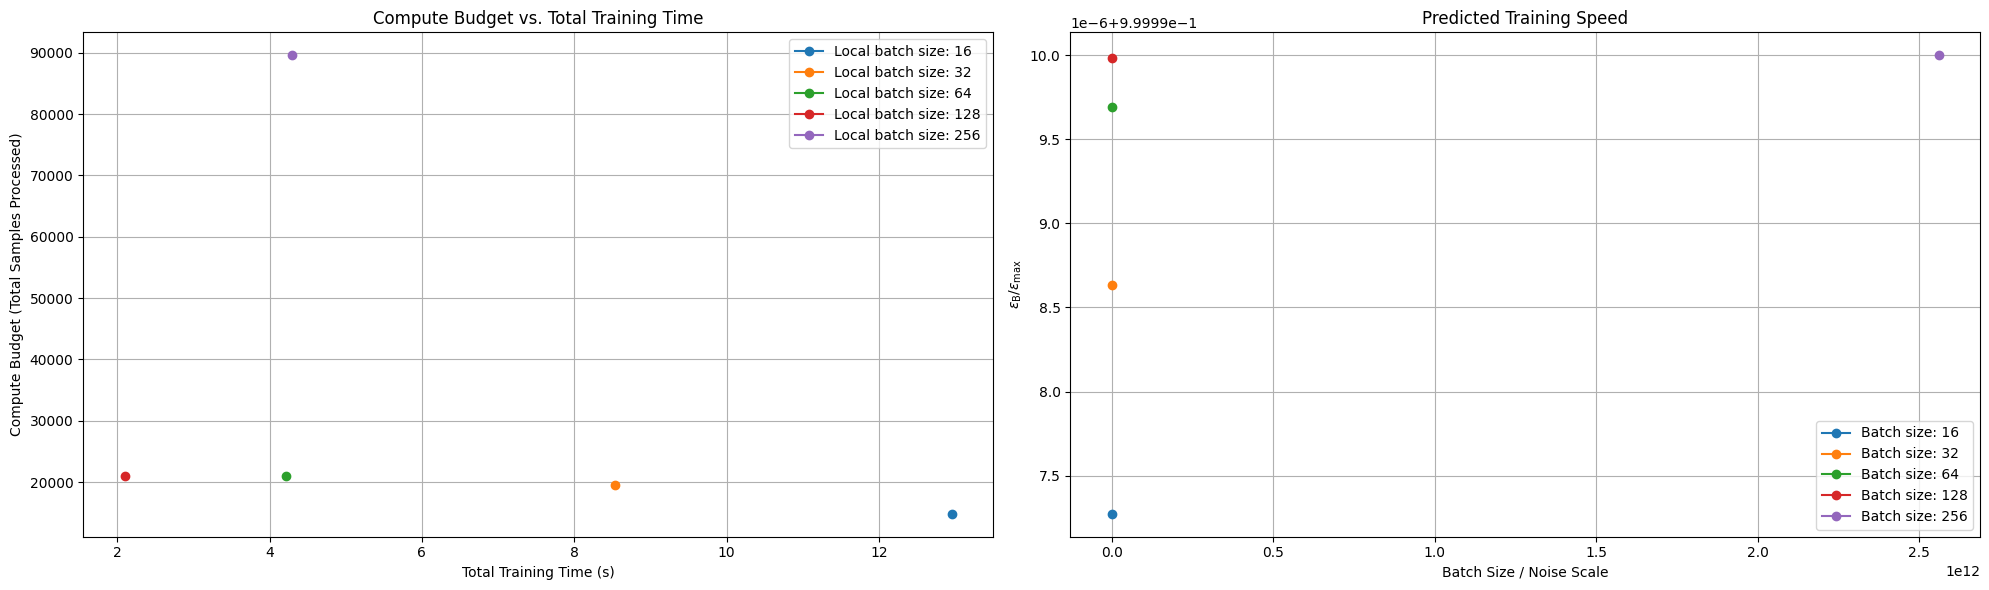

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for batch_size, params, hist in total_batch_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local batch size: {batch_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for batch_size, params, hist in total_batch_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = batch_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")

axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
for batch_size, params, hist in total_batch_results:
    print("Batch size: ", batch_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches)) 

When running FL experiments with multiple batch sizes, we do observe that there must be something as "critical" batch size.

However, we must investigate how to identify it.

# Experiment 3

### **Running FL with varying cohort sizes**

In [24]:
total_cohort_results = []

for cohort_size in cohort_sizes:
    train_cfg = federated_train_config.copy()
    ratio = np.sqrt(cohort_size / 100)
    train_cfg["client_learning_rate"] = ratio * 0.01

    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))

INFO flwr 2025-02-28 21:33:01,944 | experiments_simulation.py:200 | FL will execute for 10 rounds
WARNING flwr 2025-02-28 21:33:01,948 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-02-28 21:33:01,949 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2025-02-28 21:33:01,950 | flwr_core.py:251 | Initializing global parameters
INFO flwr 2025-02-28 21:33:01,953 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-28 21:33:01,958 | flwr_core.py:256 | Evaluating initial parameters


 11%|█         | 100/891 [00:01<00:12, 64.73it/s]
INFO flwr 2025-02-28 21:33:03,751 | flwr_core.py:259 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-02-28 21:33:03,752 | flwr_core.py:267 | FL starting - Target accuracy: 0.6
DEBUG flwr 2025-02-28 21:33:03,753 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 100)
INFO flwr 2025-02-28 21:33:03,754 | flwr_core.py:105 | cid: 937
INFO flwr 2025-02-28 21:33:03,755 | flwr_core.py:105 | cid: 1167
INFO flwr 2025-02-28 21:33:03,760 | flwr_core.py:105 | cid: 2167
INFO flwr 2025-02-28 21:33:03,761 | flwr_core.py:105 | cid: 2471
INFO flwr 2025-02-28 21:33:03,763 | flwr_core.py:105 | cid: 1287
DEBUG flwr 2025-02-28 21:33:07,784 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures
 11%|█         | 100/891 [00:01<00:10, 73.72it/s]
INFO flwr 2025-02-28 21:33:09,369 | flwr_core.py:290 | fit progress: (round 1, accuracy 0.12875, loss 3

In [28]:
for cohort_size, parameters, hist in total_cohort_results:
    save_federated_experiment(f"federated_cohort_results_{cohort_size}.pkl", cohort_size, parameters, hist)

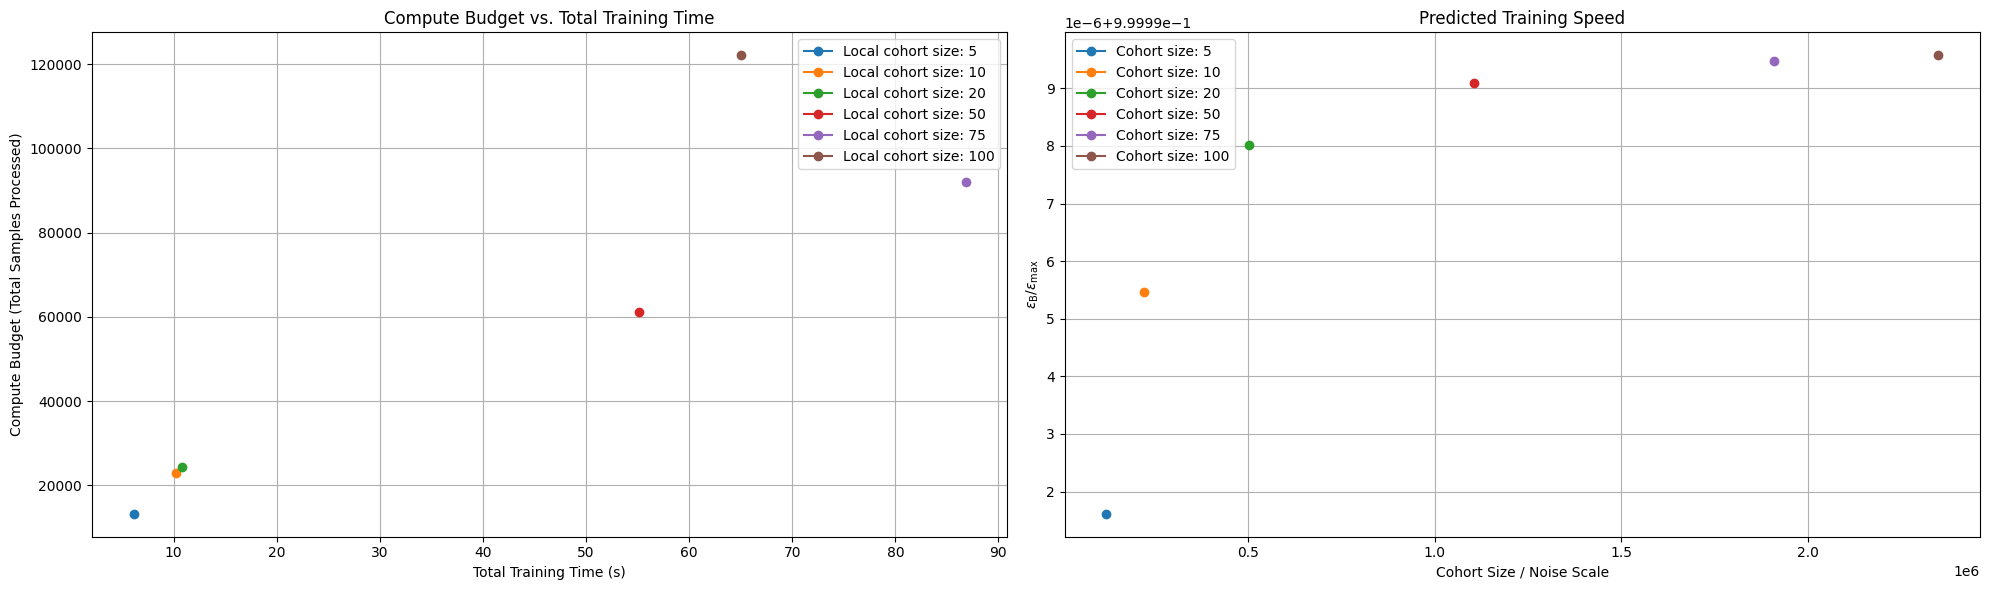

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
# Bottom-left: Compute Budget vs Training Time
for cohort_size, params, hist in total_cohort_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local cohort size: {cohort_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for cohort_size, params, hist in total_cohort_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = cohort_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / cohort_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Cohort size: {cohort_size}")

axes[1].set_xlabel("Cohort Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

When running experiment with varying client cohort sizes, we also observe that such thing as "ideal" client cohort number exists.

However, we have to investigate how to compute it.

**$\beta_\text{simple}$ integration into Federated Learning runs**


To implement the actual $\beta_\text{simple}$ ($\beta_\text{simple} \approx \beta_\text{crit}$) computation, we would need to change the client fit fn to return the gradients after training, and we would need to aggregate them in the server somehow.

In summary, we need to somehow get them to the hist or params object, and figure out a way to aggregate them.

This appears to give us a good estimate of the critical batch size. According to this estimates, the ideal batch size appears to be somewhere in the 16-64, and the optimal batch size we observe is actually 32, which is right in the middle of the range.

In [ ]:
for cohort_size, params, hist in total_cohort_results:
    print("Cohort size: ", cohort_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches))       

# Experiment 4

### **Running FL with varying batch sizes and cohort sizes**

In [24]:
total_mixed_results = []

for batch_size, cohort_size in itertools.product(experiment_batch_sizes, cohort_sizes):
    filename = f"federated_mixed_results_{batch_size}_{cohort_size}.pkl"
    with open(filename, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    results = (results_dict['batch_size'], results_dict['cohort_size'], results_dict['parameters_for_each_round'], results_dict['history'])
    total_mixed_results.append(results)

In [30]:
total_mixed_results = []
for batch_size, cohort_size in itertools.product(experiment_batch_sizes, cohort_sizes):
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256) * np.sqrt(cohort_size / 100)
    train_cfg["client_learning_rate"] = ratio * 0.01 # Same as centralized, but should be lower for FL

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    total_mixed_results.append((batch_size, cohort_size, parameters_for_each_round, hist))

INFO flwr 2025-02-28 23:48:15,417 | flwr_core.py:105 | cid: 2530
INFO flwr 2025-02-28 23:48:15,421 | flwr_core.py:105 | cid: 2184
INFO flwr 2025-02-28 23:48:15,422 | flwr_core.py:105 | cid: 2907
INFO flwr 2025-02-28 23:48:15,423 | flwr_core.py:105 | cid: 1498
INFO flwr 2025-02-28 23:48:15,425 | flwr_core.py:105 | cid: 2338
INFO flwr 2025-02-28 23:48:15,426 | flwr_core.py:105 | cid: 2399
INFO flwr 2025-02-28 23:48:15,427 | flwr_core.py:105 | cid: 2997
INFO flwr 2025-02-28 23:48:15,429 | flwr_core.py:105 | cid: 678
INFO flwr 2025-02-28 23:48:15,430 | flwr_core.py:105 | cid: 3175
INFO flwr 2025-02-28 23:48:15,431 | flwr_core.py:105 | cid: 1363
INFO flwr 2025-02-28 23:48:15,433 | flwr_core.py:105 | cid: 1571
INFO flwr 2025-02-28 23:48:15,434 | flwr_core.py:105 | cid: 2600
INFO flwr 2025-02-28 23:48:15,435 | flwr_core.py:105 | cid: 1473
INFO flwr 2025-02-28 23:48:15,436 | flwr_core.py:105 | cid: 1260
INFO flwr 2025-02-28 23:48:15,438 | flwr_core.py:105 | cid: 1603
INFO flwr 2025-02-28 23:48

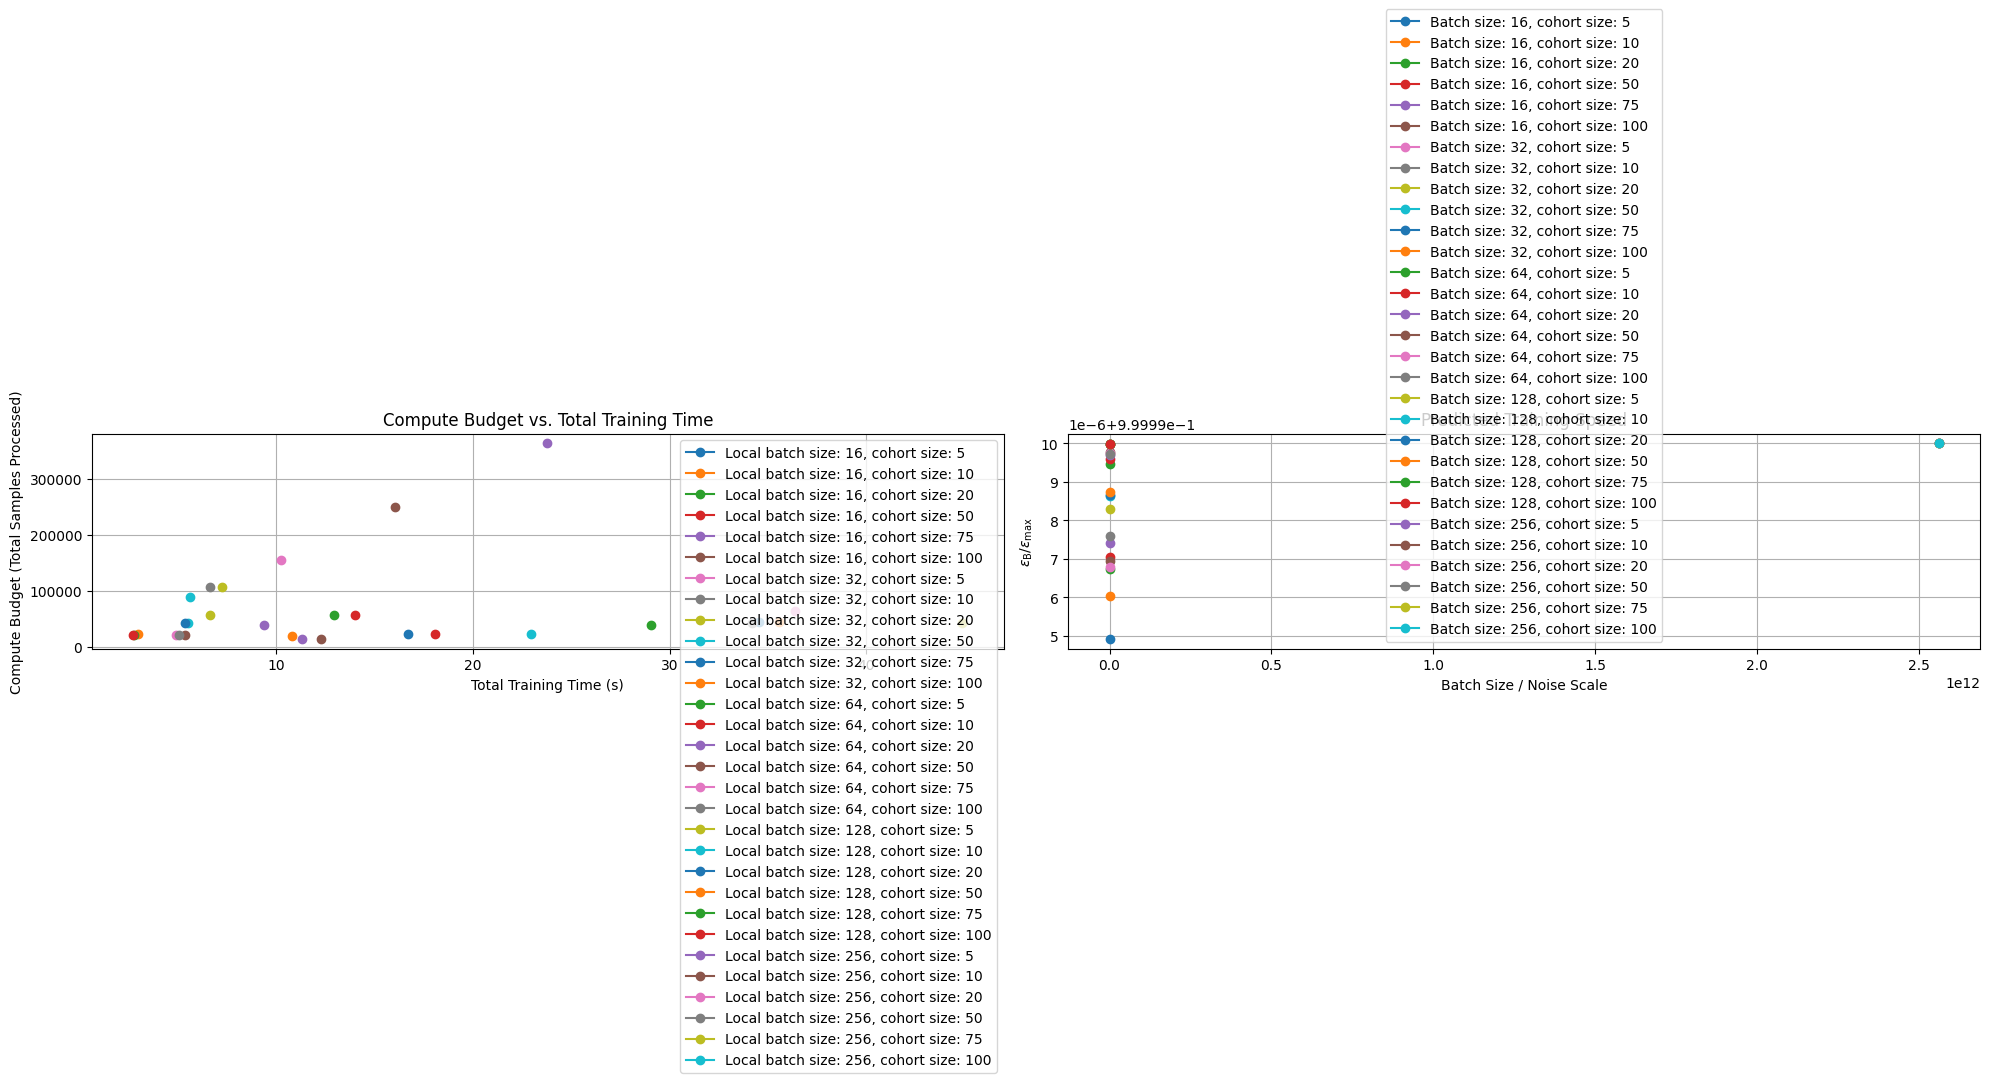

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for batch_size, cohort_size, params, hist in total_mixed_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local batch size: {batch_size}, cohort size: {cohort_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for batch_size, cohort_size, params, hist in total_mixed_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = batch_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}, cohort size: {cohort_size}")

axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [32]:
for batch_size, cohort_size, parameters, hist in total_mixed_results:
    save_file_name = f"federated_mixed_results_{batch_size}_{cohort_size}.pkl"
    if os.path.exists(save_file_name):
        raise FileExistsError(f"File {save_file_name} already exists")
    
    results_dict = {
        'batch_size': batch_size,
        'cohort_size': cohort_size,
        'parameters_for_each_round': parameters,
        'history': hist
    }
    if os.path.exists(save_file_name):
        continue
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)